In [1]:
import os
import numpy as np
import glob
from skimage.io import imread,imsave
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import tqdm
import keras
from tqdm.notebook import tqdm_notebook
import yaml
from functools import partial
from dvclive.keras import DVCLiveCallback
from loss import tversky_loss, focal_tversky,sdice_loss, dice_loss,log_cosh_dice_loss
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,LearningRateScheduler,TensorBoard
from tensorflow import keras
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from clr_callback import *

In [2]:
tf.config.list_physical_devices('GPU')
params = yaml.safe_load(open("params.yaml"))['model_params']

In [3]:
image_size = params['Image_patch_size']
mask_size = params['Mask_patch_size']
num_class = params['Number_of_classes']
lr = params['Learning_rate']
batchsize = params['Batch_size']
optimizer = params['Optimizer']
epochs = params['Epochs']

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
PATH = 'tfrecords/'
BATCH_SIZE = batchsize

In [5]:
FILENAMES = tf.io.gfile.glob(PATH +"*large_images.tfrecords")
split_ind = int(0.7 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))

Train TFRecord Files: 10
Validation TFRecord Files: 5


In [6]:
def read_tfrecord(example):
    tfrecord_format = (
        {
         "image":tf.io.FixedLenFeature(shape=[*image_size], dtype=tf.float32),
         "mask":tf.io.FixedLenFeature(shape=[*mask_size], dtype=tf.float32)
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = example["image"]
    mask = example["mask"]
    mask = tf.one_hot(tf.cast(mask, tf.uint8), 2)
    return image,mask

In [7]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [8]:
seed=42

In [9]:
def augmentation(image, mask):
    # both use the same seed, so they'll make the same random changes
    flip_image = tf.image.random_flip_left_right(image,seed=seed)
    flip_mask = tf.image.random_flip_left_right(mask,seed=seed)
    # Other transformations...
    return flip_image, flip_mask

In [10]:
def get_dataset(filenames):
    dataset = tf.data.Dataset.range(10)
    dataset = load_dataset(filenames).cache().repeat()
    # to avoid data loss error
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [11]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)

  0%|          | 0/3 [00:00<?, ?it/s]

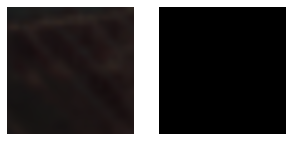

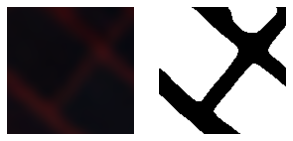

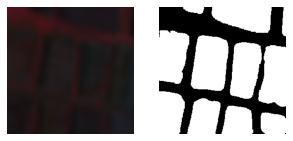

In [12]:
image_batch, label_batch = next(iter(train_dataset))
for i in tqdm_notebook(range(3)):
    image = image_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

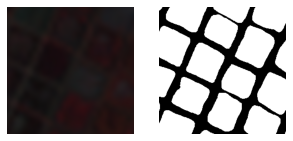

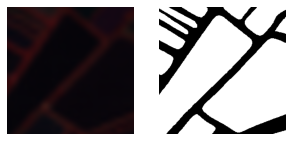

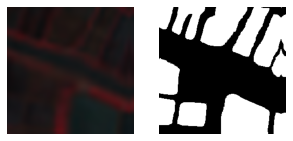

In [13]:
testimage_batch, label_batch = next(iter(valid_dataset))
for i in tqdm_notebook(range(3)):
    image = testimage_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [14]:
# GPUS = ["GPU:0","GPU:1","GPU:2","GPU:3"]
# strategy = tf.distribute.MirroredStrategy( GPUS )
# print('Number of devices: %d' % strategy.num_replicas_in_sync)

In [15]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4


In [16]:
# input dimensions, no. of channels, and no. of classes for the model
IMG_HEIGHT = image_batch.shape[1]
IMG_WIDTH  = image_batch.shape[2]
IMG_CHANNELS = image_batch.shape[3]
n_classes=num_class

In [17]:
def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


def ASPP(image_features):

    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=128, kernel_size=1, padding='same', dilation_rate = 12,use_bias=False)(image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y

In [18]:
def DeepLabV3PlusSE(inputs, classes=1):

    inputs = Input(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    high_level_image_features = base_model.get_layer('conv4_block6_add').output
    high_level_image_features = SqueezeAndExcitation(high_level_image_features, ratio=16)
    
    x_a = ASPP(high_level_image_features)
    x_a = SqueezeAndExcitation(x_a, ratio=16)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    low_level_image_features = base_model.get_layer('conv2_block3_add').output
    low_level_image_features = SqueezeAndExcitation(low_level_image_features, ratio=16)

    x_b = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)
    
    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

In [19]:
# calculation of steps per epoch for traning and validation
filespershard = 500
number_of_shards = len(glob.glob(PATH+'*.tfrecords'))
steps_per_epoch = (number_of_shards*filespershard*0.7)// BATCH_SIZE
val_steps_per_epoch = (number_of_shards*filespershard*0.3)//BATCH_SIZE

In [20]:

import math
epochs=epochs
learning_rate = lr
scheduler = params['Scheduler']

if scheduler == 'Exponential':
    decay_rate = learning_rate / epochs
    def exp_decay(epoch):
        lrate = learning_rate * np.exp(-decay_rate*epoch)
        return lrate
    lr_rate = LearningRateScheduler(exp_decay)
elif scheduler == 'Step_decay':
    def step_decay(epoch):
        initial_lrate = learning_rate
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop,  
                math.floor((1+epoch)/epochs_drop))
        return lrate
    lr_rate = LearningRateScheduler(step_decay)
elif scheduler == 'Cycliclearning_rate':
    clr_triangular = CyclicLR(mode='triangular')
    clr_triangular._reset(new_base_lr=0.00005, new_max_lr=0.0001)
    lr_rate = clr_triangular

In [21]:
loss = params['Loss']
if loss == 'sdice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=sdice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'focal_tversky':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=focal_tversky,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'tversky_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=tversky_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'log_cosh_dice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=log_cosh_dice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [22]:
#ModelCheckpoint callback saves a model at some interval. 
checkpoint_path = 'model_checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
filepath=checkpoint_path+"resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_one_hot_io_u', verbose=1, save_best_only=True, mode='max')

In [23]:
# earlystop for stopping the model when there is no improvement
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# log_csv = CSVLogger('/home/ubuntu/Notebooks for Unet_training/models for deeplab+SE v5/tversky-logs/sdice_lossv1.csv', separator=',', append=False)

In [24]:
from IPython.display import clear_output
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=3)
    return pred_mask[0]
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.show()

def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample
            masks = tf.math.argmax(masks[0], axis=2)
            pred_masks = model.predict(images)
            display([images[0], masks, create_mask(pred_masks)])
    else:
        display(
            [
                testimage_batch[0], tf.math.argmax(label_batch[0], axis=2),
                create_mask(model.predict(testimage_batch)),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [25]:
callbacks_list = [checkpoint,early_stop,lr_rate,DVCLiveCallback(dir='evaluation',save_dvc_exp=True),DisplayCallback(valid_dataset)]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 221ms/step


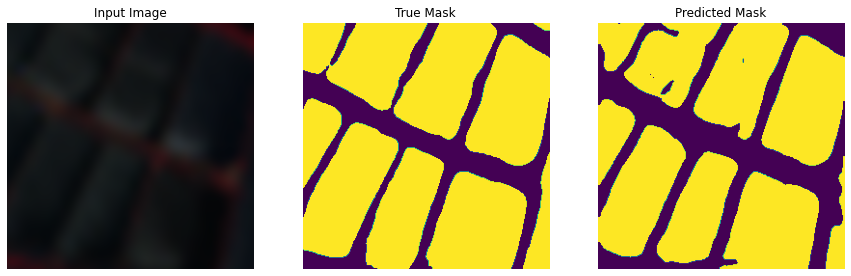


Sample Prediction after epoch 66


328/328 [==============================] - 38s 117ms/step - loss: 0.0103 - one_hot_io_u: 0.9711 - precision: 0.9859 - recall: 0.9859 - val_loss: 0.0800 - val_one_hot_io_u: 0.8169 - val_precision: 0.9069 - val_recall: 0.9069


Epoch 66: early stopping


CPU times: user 2h 43min 30s, sys: 12min 59s, total: 2h 56min 30s

Wall time: 44min 27s

In [26]:
%%time
history=model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          verbose=1,
          validation_data=valid_dataset,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks_list,
          )

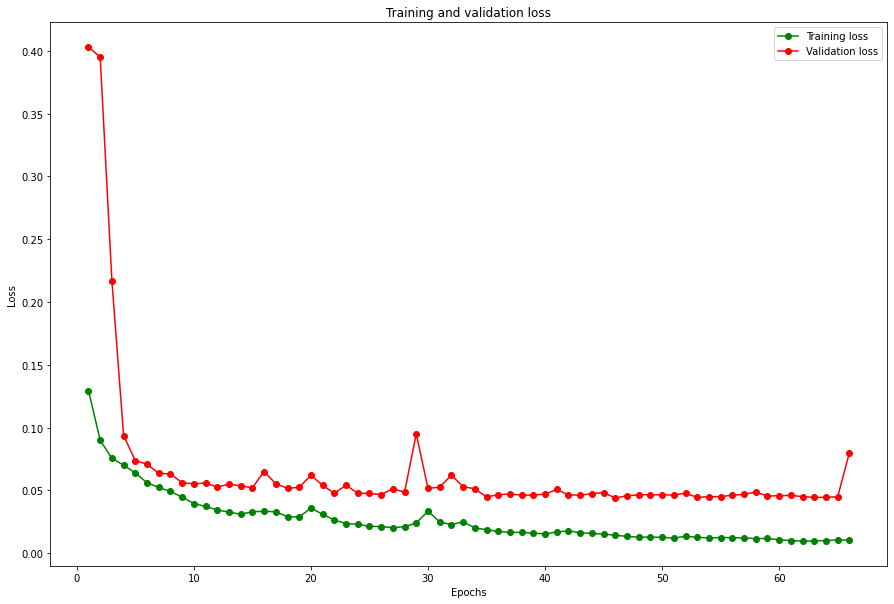

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'green', label='Training loss', marker = 'o')
plt.plot(epochs, val_loss, 'r', label='Validation loss', marker = 'o')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('loss_graph.png')
plt.show()

In [28]:
acc = history.history['one_hot_io_u']
val_acc = history.history['val_one_hot_io_u']

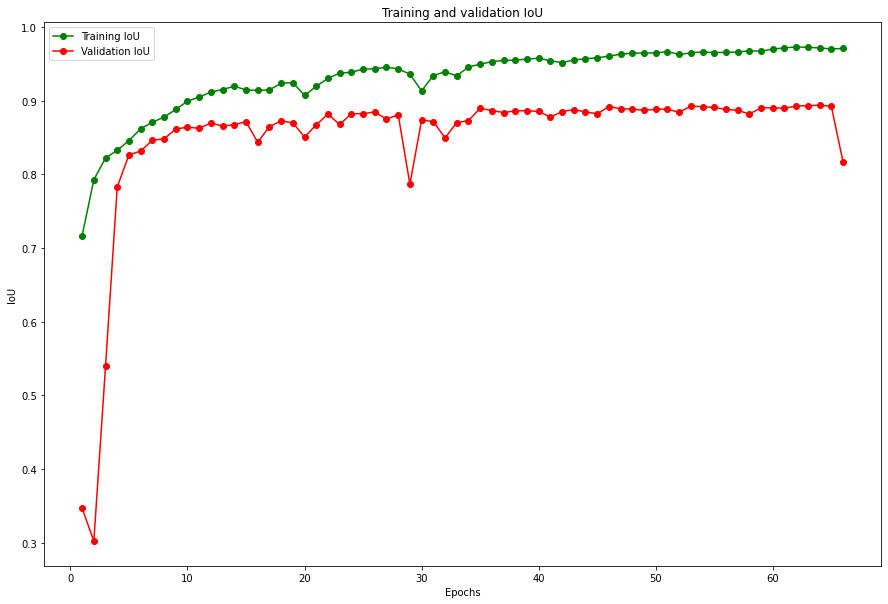

In [29]:
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'green', label='Training IoU', marker = 'o')
plt.plot(epochs, val_acc, 'r', label='Validation IoU', marker = 'o')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
# plt.savefig('auccuracy_graph.png')
plt.show()

In [30]:
from keras.models import load_model

model = load_model(filepath, compile=False)

In [31]:
from tensorflow.keras.metrics import MeanIoU

In [32]:
test_image_batch, test_mask_batch = next(iter(valid_dataset))

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


Mean IoU =

0.9059234

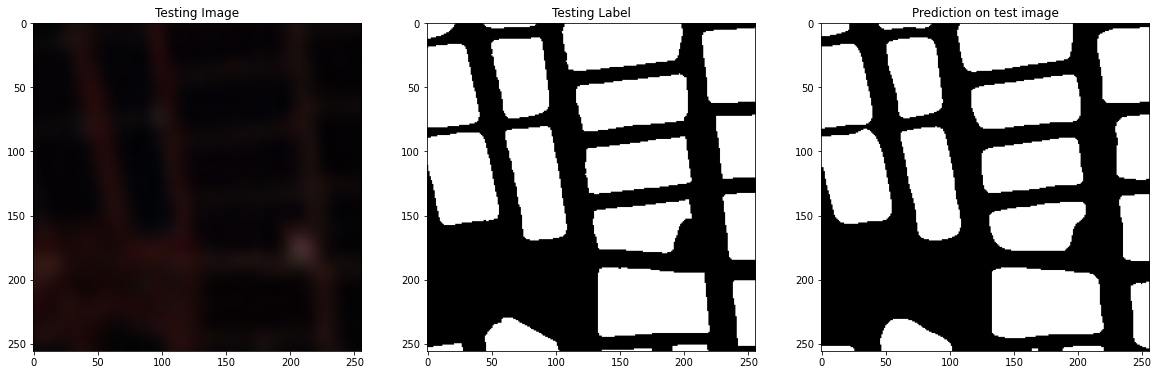

In [33]:
img_num = random.randint(0, test_image_batch.shape[0]-1)
image = test_image_batch[img_num]
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image[:,:,0:3])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num], cmap='gray')
plt.show()

In [34]:
No_of_valid_data = int(number_of_shards*filespershard*0.3)

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [36]:
test_image_batch, test_mask_batch = next(iter(valid_dataset.unbatch().batch(No_of_valid_data)))
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

 1/71 [..............................] - ETA: 1:03

 3/71 [>.............................] - ETA: 2s  

 4/71 [>.............................] - ETA: 3s

 5/71 [=>............................] - ETA: 3s

 6/71 [=>............................] - ETA: 3s

 7/71 [=>............................] - ETA: 3s

 8/71 [==>...........................] - ETA: 3s

 9/71 [==>...........................] - ETA: 3s

10/71 [===>..........................] - ETA: 3s

11/71 [===>..........................] - ETA: 3s

12/71 [====>.........................] - ETA: 3s

13/71 [====>.........................] - ETA: 3s

14/71 [====>.........................] - ETA: 3s

15/71 [=====>........................] - ETA: 3s

16/71 [=====>........................] - ETA: 3s

17/71 [======>.......................] - ETA: 3s

18/71 [======>.......................] - ETA: 3s

19/71 [=======>......................] - ETA: 3s

20/71 [=======>......................] - ETA: 3s

21/71 [=======>......................] - ETA: 3s

22/71 [========>.....................] - ETA: 3s

23/71 [========>.....................] - ETA: 3s

24/71 [=========>....................] - ETA: 2s

25/71 [=========>....................] - ETA: 2s

26/71 [=========>....................] - ETA: 2s

27/71 [==========>...................] - ETA: 2s

28/71 [==========>...................] - ETA: 2s

29/71 [===========>..................] - ETA: 2s

30/71 [===========>..................] - ETA: 2s

31/71 [============>.................] - ETA: 2s

32/71 [============>.................] - ETA: 2s

33/71 [============>.................] - ETA: 2s

34/71 [=============>................] - ETA: 2s

35/71 [=============>................] - ETA: 2s

36/71 [==============>...............] - ETA: 2s

37/71 [==============>...............] - ETA: 2s

38/71 [===============>..............] - ETA: 2s

39/71 [===============>..............] - ETA: 2s

40/71 [===============>..............] - ETA: 1s

41/71 [================>.............] - ETA: 1s

42/71 [================>.............] - ETA: 1s

43/71 [=================>............] - ETA: 1s

44/71 [=================>............] - ETA: 1s

45/71 [==================>...........] - ETA: 1s

46/71 [==================>...........] - ETA: 1s

47/71 [==================>...........] - ETA: 1s

48/71 [===================>..........] - ETA: 1s

49/71 [===================>..........] - ETA: 1s

50/71 [====================>.........] - ETA: 1s

51/71 [====================>.........] - ETA: 1s

52/71 [====================>.........] - ETA: 1s

53/71 [=====================>........] - ETA: 1s

54/71 [=====================>........] - ETA: 1s

55/71 [======================>.......] - ETA: 1s

56/71 [======================>.......] - ETA: 0s

57/71 [=======================>......] - ETA: 0s

58/71 [=======================>......] - ETA: 0s

59/71 [=======================>......] - ETA: 0s

60/71 [========================>.....] - ETA: 0s

61/71 [========================>.....] - ETA: 0s

62/71 [=========================>....] - ETA: 0s

63/71 [=========================>....] - ETA: 0s

64/71 [==========================>...] - ETA: 0s

65/71 [==========================>...] - ETA: 0s

66/71 [==========================>...] - ETA: 0s

67/71 [===========================>..] - ETA: 0s

68/71 [===========================>..] - ETA: 0s

69/71 [============================>.] - ETA: 0s

70/71 [============================>.] - ETA: 0s

71/71 [==============================] - ETA: 0s

71/71 [==============================] - 6s 71ms/step


In [37]:
cm = confusion_matrix(test_mask_batch_argmax.flatten(),test_pred_batch_argmax.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non_ponds','ponds'])

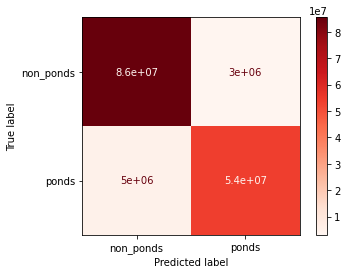

In [38]:
disp.plot(cmap=plt.cm.Reds)
plt.savefig('confusion_matrix.png')
plt.show()